In [ ]:
import random
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.ToTensor()
cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split images
class_images = [[] for _ in range(10)]
for img, label in cifar10:
    class_images[label].append(img)

# Selecting 15 images per class
selected_images = []
for images in class_images:
    selected_images.extend(random.sample(images, 15))

100%|██████████| 170M/170M [00:02<00:00, 78.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


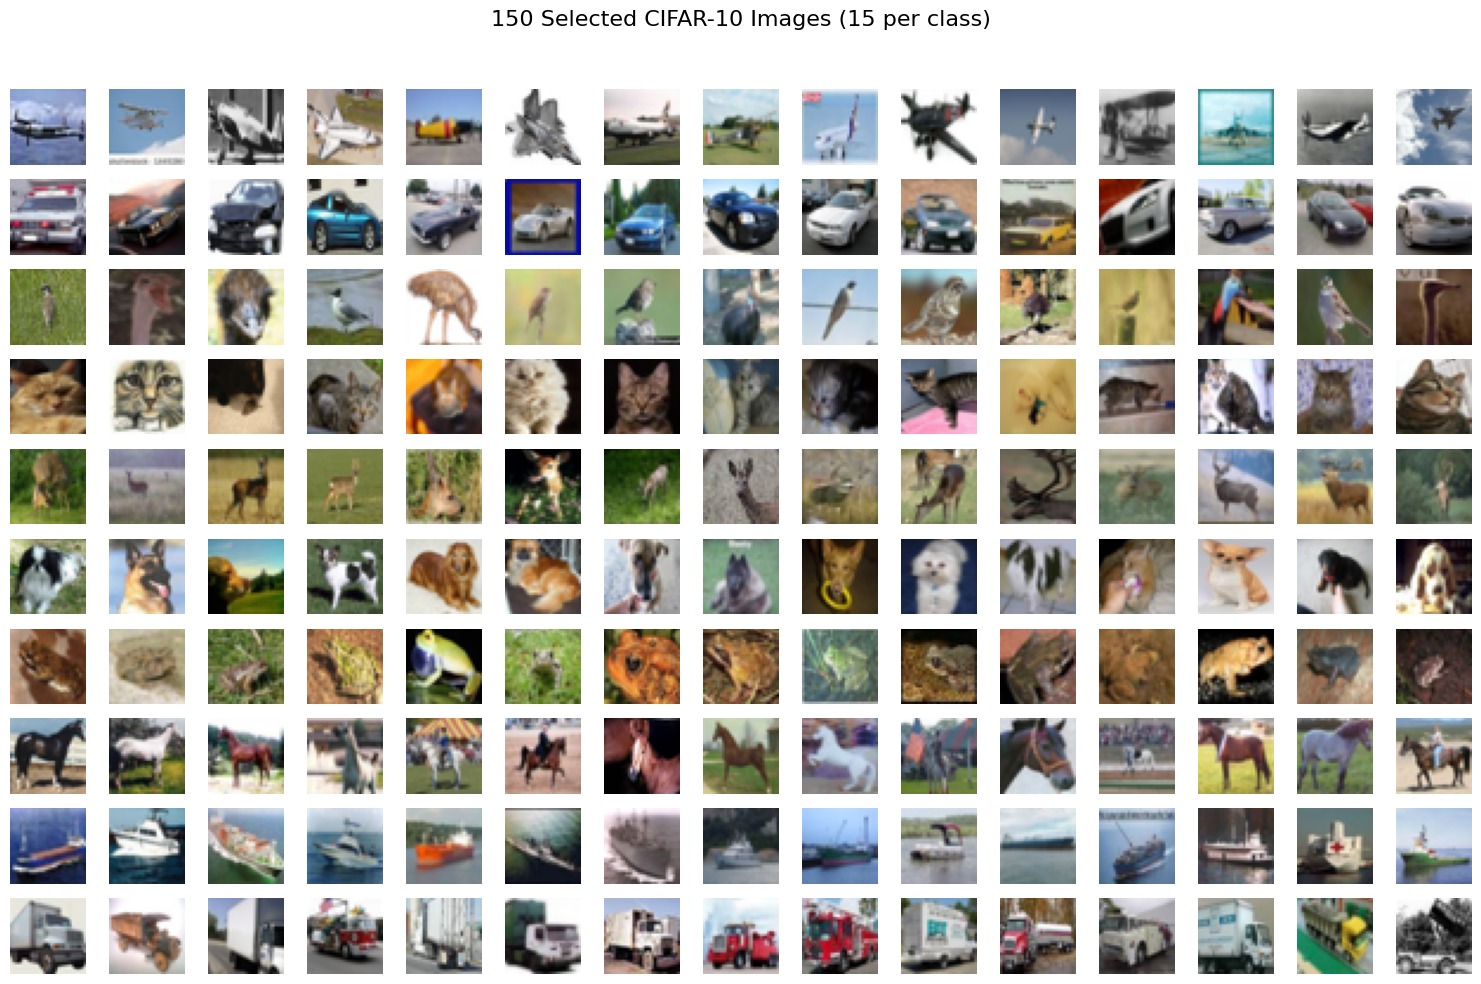

In [ ]:
# Plot the selected images
fig, axes = plt.subplots(10, 15, figsize=(15, 10))
fig.suptitle("150 Selected CIFAR-10 Images (15 per class)", fontsize=16)

for i in range(10):
    for j in range(15):
        img = selected_images[i * 15 + j].permute(1, 2, 0).numpy()

        axes[i, j].imshow(img)
        axes[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0.0, std=0.05):
    noise = torch.randn(image.size()) * std + mean  # Generate Gaussian noise
    noisy_image = image + noise  # Add noise to the original image
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)  # Ensure pixel values remain between 0 and 1
    return noisy_image

In [ ]:
# Function to represent images as matrices
def represent_images_as_matrices(images):
    matrices = []
    for image in images:
        noisy_image = add_gaussian_noise(image)
        image_matrix = (noisy_image.permute(1, 2, 0).numpy() * 255).astype(int)
        matrices.append(image_matrix)

    return matrices

In [ ]:
# Function to apply SVD to image matrix
def apply_svd_to_images(matrices):
    svd_results = []
    for matrix in matrices:
        R = matrix[:, :, 0].astype(np.float32)
        G = matrix[:, :, 1].astype(np.float32)
        B = matrix[:, :, 2].astype(np.float32)

        U_R, S_R, Vt_R = np.linalg.svd(R, full_matrices=False)
        U_G, S_G, Vt_G = np.linalg.svd(G, full_matrices=False)
        U_B, S_B, Vt_B = np.linalg.svd(B, full_matrices=False)

        svd_results.append(((U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B)))

    return svd_results

In [ ]:
def truncate_to_top_k_singular_values(svd_results, k=50):
    truncated_images = []
    for (U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B) in svd_results:

        S_R_truncated = np.zeros_like(S_R)
        S_R_truncated[:k] = S_R[:k]

        S_G_truncated = np.zeros_like(S_G)
        S_G_truncated[:k] = S_G[:k]

        S_B_truncated = np.zeros_like(S_B)
        S_B_truncated[:k] = S_B[:k]

        reconstructed_R = np.dot(U_R, np.dot(np.diag(S_R_truncated), Vt_R))
        reconstructed_G = np.dot(U_G, np.dot(np.diag(S_G_truncated), Vt_G))
        reconstructed_B = np.dot(U_B, np.dot(np.diag(S_B_truncated), Vt_B))

        reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1)

        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        truncated_images.append(reconstructed_image)

    return truncated_images


In [ ]:
# Function to truncate small singular values
def truncate_small_singular_values(svd_results, threshold=50):
    truncated_images = []
    for (U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B) in svd_results:

        S_R_truncated = np.where(S_R < threshold, 0, S_R)
        S_G_truncated = np.where(S_G < threshold, 0, S_G)
        S_B_truncated = np.where(S_B < threshold, 0, S_B)

        reconstructed_R = np.dot(U_R, np.dot(np.diag(S_R_truncated), Vt_R))
        reconstructed_G = np.dot(U_G, np.dot(np.diag(S_G_truncated), Vt_G))
        reconstructed_B = np.dot(U_B, np.dot(np.diag(S_B_truncated), Vt_B))

        reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1)

        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        truncated_images.append(reconstructed_image)

    return truncated_images


In [ ]:
# Function to reconstruct the denoised image
def reconstruct_denoised_image(svd_results):
    denoised_images = []
    for (U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B) in svd_results:

        S_R_truncated = np.where(S_R < 50, 0, S_R)
        S_G_truncated = np.where(S_G < 50, 0, S_G)
        S_B_truncated = np.where(S_B < 50, 0, S_B)

        reconstructed_R = np.dot(U_R, np.dot(np.diag(S_R_truncated), Vt_R))
        reconstructed_G = np.dot(U_G, np.dot(np.diag(S_G_truncated), Vt_G))
        reconstructed_B = np.dot(U_B, np.dot(np.diag(S_B_truncated), Vt_B))

        reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1)

        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        denoised_images.append(reconstructed_image)

    return denoised_images

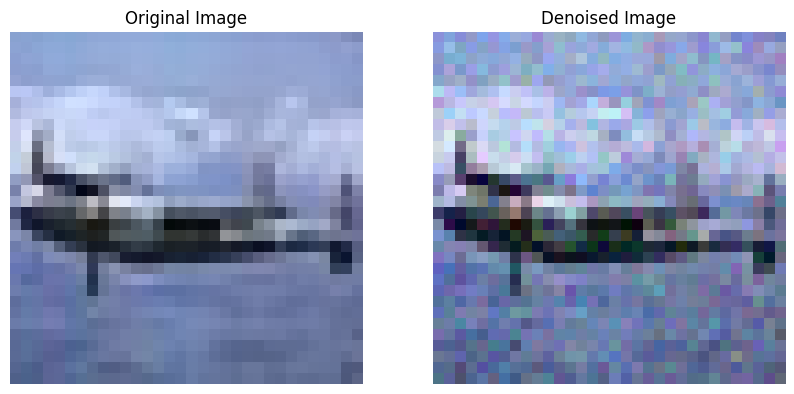

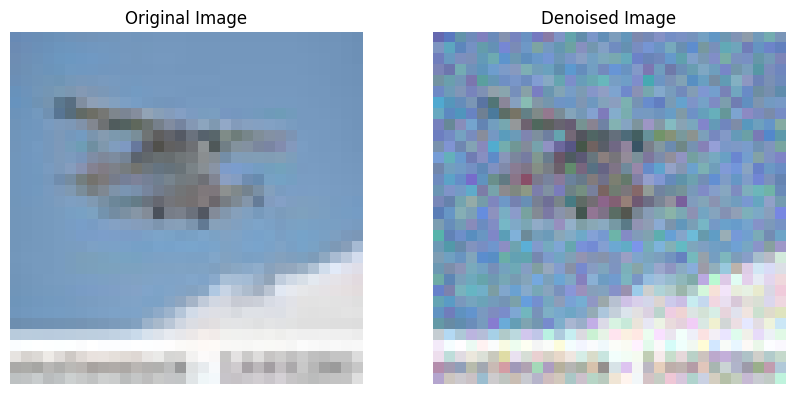

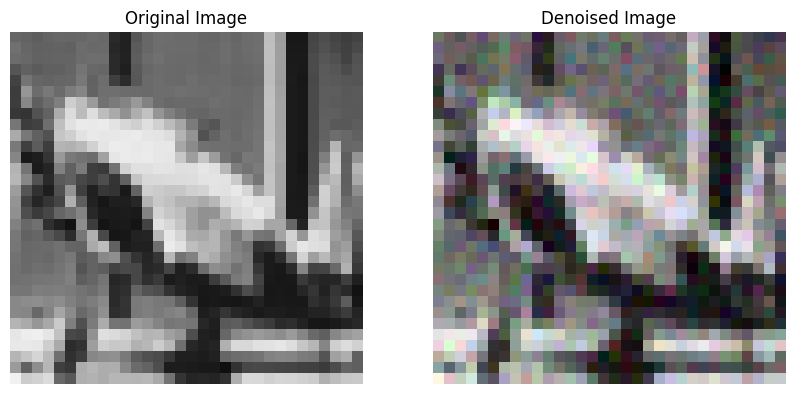

In [ ]:
# Apply the functions
noisy_matrices = represent_images_as_matrices(selected_images)
svd_results = apply_svd_to_images(noisy_matrices)

if svd_results is not None:
    truncated_images = truncate_small_singular_values(svd_results, threshold=50)

    denoised_images = reconstruct_denoised_image(svd_results)

    for i in range(3):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(selected_images[i].permute(1, 2, 0).numpy())
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(denoised_images[i])
        plt.title("Denoised Image")
        plt.axis('off')

        plt.show()
else:
    print("SVD results are empty. Check for errors in the previous steps.")

In [ ]:
def calculate_metrics(original_images, denoised_images):
    psnr_values = []
    mse_values = []
    ssim_values = []

    for original, denoised in zip(original_images, denoised_images):

        original = (original.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        denoised = denoised.astype(np.uint8)

        psnr_value = psnr(original, denoised, data_range=255)
        psnr_values.append(psnr_value)

        mse_value = mse(original, denoised)
        mse_values.append(mse_value)

        ssim_value = ssim(original, denoised, data_range=255, win_size=3, channel_axis=-1)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_mse = np.mean(mse_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average MSE: {avg_mse:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_mse, avg_ssim

average_psnr, average_mse, average_ssim = calculate_metrics(selected_images, denoised_images)



Average PSNR: 26.28 dB
Average MSE: 153.49
Average SSIM: 0.6932


Average PSNR: 26.94 dB
Average MSE: 133.21
Average SSIM: 0.7262
k = 10 | Average PSNR: 26.94 dB, Average MSE: 133.21, Average SSIM: 0.7262
Average PSNR: 26.13 dB
Average MSE: 158.62
Average SSIM: 0.6870
k = 30 | Average PSNR: 26.13 dB, Average MSE: 158.62, Average SSIM: 0.6870
Average PSNR: 26.13 dB
Average MSE: 158.69
Average SSIM: 0.6868
k = 50 | Average PSNR: 26.13 dB, Average MSE: 158.69, Average SSIM: 0.6868
Average PSNR: 26.13 dB
Average MSE: 158.69
Average SSIM: 0.6868
k = 100 | Average PSNR: 26.13 dB, Average MSE: 158.69, Average SSIM: 0.6868


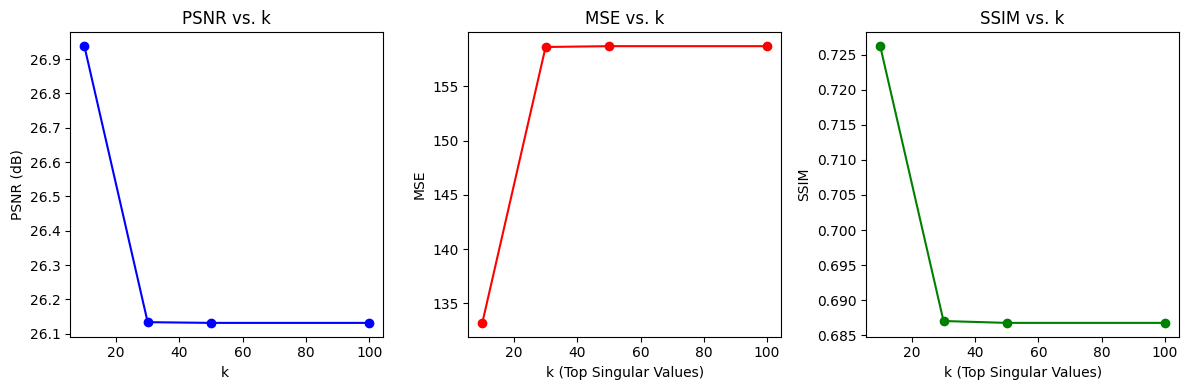

In [ ]:
# Hyperparameter analysis
k_values = [10, 30, 50, 100]
metrics_results = {"k": [], "PSNR": [], "MSE": [], "SSIM": []}

for k in k_values:
    truncated_images = truncate_to_top_k_singular_values(svd_results, k)
    avg_psnr, avg_mse, avg_ssim = calculate_metrics(selected_images, truncated_images)

    metrics_results["k"].append(k)
    metrics_results["PSNR"].append(avg_psnr)
    metrics_results["MSE"].append(avg_mse)
    metrics_results["SSIM"].append(avg_ssim)

    print(f"k = {k} | Average PSNR: {avg_psnr:.2f} dB, Average MSE: {avg_mse:.2f}, Average SSIM: {avg_ssim:.4f}")


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(metrics_results["k"], metrics_results["PSNR"], marker='o', color='b')
plt.xlabel('k ')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. k')

plt.subplot(1, 3, 2)
plt.plot(metrics_results["k"], metrics_results["MSE"], marker='o', color='r')
plt.xlabel('k (Top Singular Values)')
plt.ylabel('MSE')
plt.title('MSE vs. k')

plt.subplot(1, 3, 3)
plt.plot(metrics_results["k"], metrics_results["SSIM"], marker='o', color='g')
plt.xlabel('k (Top Singular Values)')
plt.ylabel('SSIM')
plt.title('SSIM vs. k')

plt.tight_layout()
plt.show()

In [ ]:
 # Calculate PSNR between original and denoised images
for i in range(len(selected_images)):
    original_image = (selected_images[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    denoised_image = denoised_images[i]
    psnr_value = psnr(original_image, denoised_image, data_range=255)
    print(f"Image {i+1} PSNR: {psnr_value:.2f} dB")


Image 1 PSNR: 26.30 dB
Image 2 PSNR: 26.24 dB
Image 3 PSNR: 26.11 dB
Image 4 PSNR: 26.44 dB
Image 5 PSNR: 26.25 dB
Image 6 PSNR: 26.88 dB
Image 7 PSNR: 26.48 dB
Image 8 PSNR: 26.02 dB
Image 9 PSNR: 26.23 dB
Image 10 PSNR: 26.94 dB
Image 11 PSNR: 26.18 dB
Image 12 PSNR: 26.16 dB
Image 13 PSNR: 26.59 dB
Image 14 PSNR: 26.20 dB
Image 15 PSNR: 26.24 dB
Image 16 PSNR: 26.32 dB
Image 17 PSNR: 26.52 dB
Image 18 PSNR: 26.63 dB
Image 19 PSNR: 26.02 dB
Image 20 PSNR: 26.12 dB
Image 21 PSNR: 26.25 dB
Image 22 PSNR: 26.00 dB
Image 23 PSNR: 26.50 dB
Image 24 PSNR: 26.25 dB
Image 25 PSNR: 26.30 dB
Image 26 PSNR: 26.22 dB
Image 27 PSNR: 26.52 dB
Image 28 PSNR: 26.08 dB
Image 29 PSNR: 26.01 dB
Image 30 PSNR: 26.79 dB
Image 31 PSNR: 26.01 dB
Image 32 PSNR: 26.05 dB
Image 33 PSNR: 26.43 dB
Image 34 PSNR: 26.06 dB
Image 35 PSNR: 26.96 dB
Image 36 PSNR: 26.14 dB
Image 37 PSNR: 26.34 dB
Image 38 PSNR: 26.15 dB
Image 39 PSNR: 26.31 dB
Image 40 PSNR: 26.18 dB
Image 41 PSNR: 25.98 dB
Image 42 PSNR: 26.07 dB
I